# Flower Classification Convnet

## Loading the Data

In [2]:
# Loading the libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

In [3]:
# The data source
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

# Loading the data
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 3s 0us/step


## Basic Exploration

In [4]:
image_count = len(list(data_dir.glob("*/*.jpg")))
print("Number of images: {}".format(image_count))

Number of images: 3670


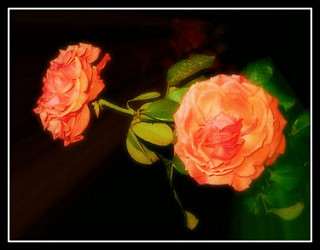

In [5]:
roses = list(data_dir.glob("roses/*"))
PIL.Image.open(str(roses[0]))

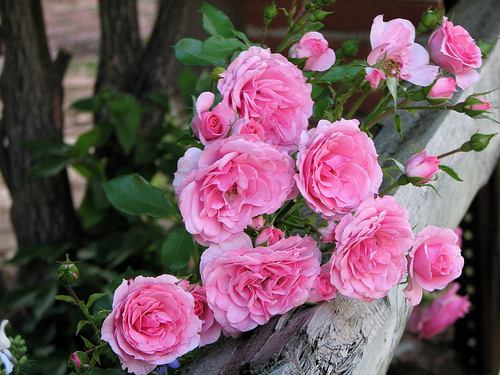

In [6]:

PIL.Image.open(str(roses[1]))

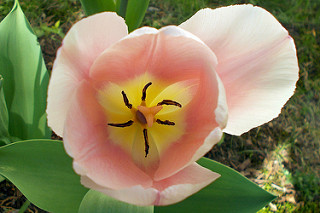

In [7]:
tulips = list(data_dir.glob("tulips/*"))
PIL.Image.open(str(tulips[0]))

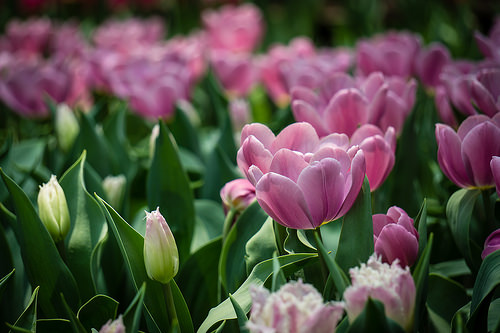

In [8]:

PIL.Image.open(str(tulips[1]))

## Train-Test Split

In [9]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [10]:
class_names = train_ds.class_names

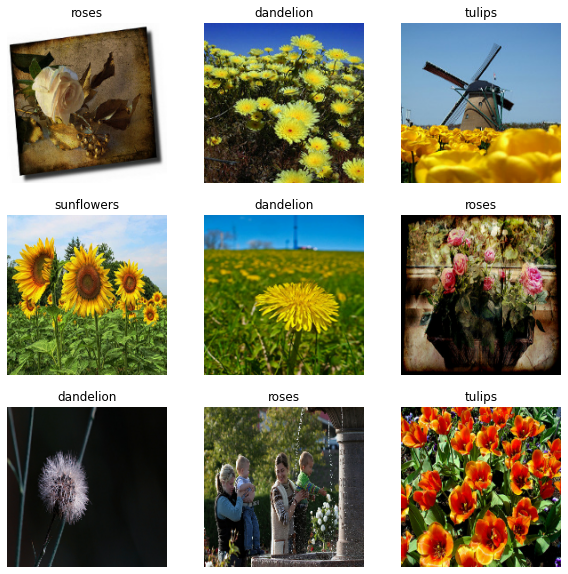

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
# Optimize dataset loading for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Building the Model

In [13]:
from tensorflow.keras import layers

num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1. / 255.,
                                              input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, activation='relu', padding='same'),
  layers.MaxPool2D(),
  layers.Conv2D(32, 3, activation='relu', padding='same'),
  layers.MaxPool2D(),
  layers.Conv2D(64, 3, activation='relu', padding='same'),
  layers.MaxPool2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Training

In [16]:
epochs = 10
history = model.fit(train_ds, validation_data=valid_ds, epochs=epochs)

Epoch 1/10
92/92 [==============================] - 97s 975ms/step - loss: 1.5286 - accuracy: 0.3588 - val_loss: 1.0664 - val_accuracy: 0.5954
Epoch 2/10
92/92 [==============================] - 89s 964ms/step - loss: 0.9907 - accuracy: 0.6161 - val_loss: 0.9791 - val_accuracy: 0.6281
Epoch 3/10
92/92 [==============================] - 89s 972ms/step - loss: 0.8286 - accuracy: 0.6851 - val_loss: 0.8753 - val_accuracy: 0.6580
Epoch 4/10
92/92 [==============================] - 90s 975ms/step - loss: 0.5961 - accuracy: 0.7834 - val_loss: 1.0649 - val_accuracy: 0.6349
Epoch 5/10
92/92 [==============================] - 87s 947ms/step - loss: 0.3845 - accuracy: 0.8674 - val_loss: 1.1252 - val_accuracy: 0.6349
Epoch 6/10
92/92 [==============================] - 89s 967ms/step - loss: 0.2181 - accuracy: 0.9298 - val_loss: 1.5431 - val_accuracy: 0.6131
Epoch 7/10
92/92 [==============================] - 89s 969ms/step - loss: 0.1301 - accuracy: 0.9619 - val_loss: 1.3780 - val_accuracy: 0.6431

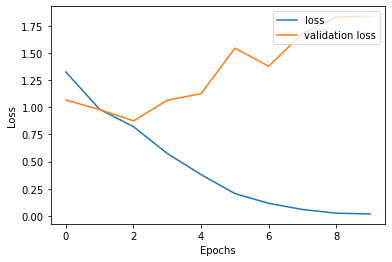

In [17]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


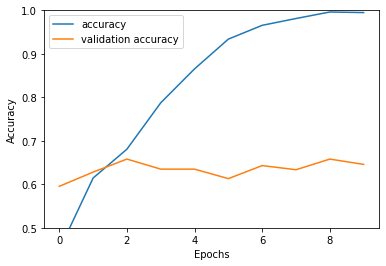

In [18]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

There is a significant gap between the training and validation accuracies. We will try adding `Dropout` layers to reduce this overfitting.

## Model Improvement

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal',
                                               input_shape=(img_height, img_width, 3)),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1)
])

In [20]:
model2 = tf.keras.Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, activation='relu', padding='same'),
  layers.MaxPool2D(),
  layers.Conv2D(32, 3, activation='relu', padding='same'),
  layers.MaxPool2D(),
  layers.Conv2D(64, 3, activation='relu', padding='same'),
  layers.MaxPool2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5)
])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

In [21]:
model2.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [22]:
epochs = 10
history2 = model2.fit(train_ds, validation_data=valid_ds, epochs=epochs)

Epoch 1/10
92/92 [==============================] - 102s 1s/step - loss: 64.9736 - accuracy: 0.2936 - val_loss: 1.4178 - val_accuracy: 0.4087
Epoch 2/10
92/92 [==============================] - 101s 1s/step - loss: 1.3479 - accuracy: 0.4229 - val_loss: 1.2559 - val_accuracy: 0.4659
Epoch 3/10
92/92 [==============================] - 101s 1s/step - loss: 1.1887 - accuracy: 0.5182 - val_loss: 1.1408 - val_accuracy: 0.5245
Epoch 4/10
92/92 [==============================] - 101s 1s/step - loss: 1.1255 - accuracy: 0.5569 - val_loss: 1.0777 - val_accuracy: 0.5804
Epoch 5/10
92/92 [==============================] - 102s 1s/step - loss: 1.0234 - accuracy: 0.6085 - val_loss: 1.1329 - val_accuracy: 0.5627
Epoch 6/10
92/92 [==============================] - 101s 1s/step - loss: 1.0043 - accuracy: 0.6169 - val_loss: 1.0099 - val_accuracy: 0.6076
Epoch 7/10
92/92 [==============================] - 100s 1s/step - loss: 0.9656 - accuracy: 0.6261 - val_loss: 1.0647 - val_accuracy: 0.5940
Epoch 8/10
9

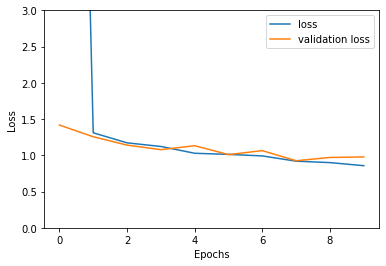

In [23]:
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 3])
plt.legend(loc='upper right')
plt.show()

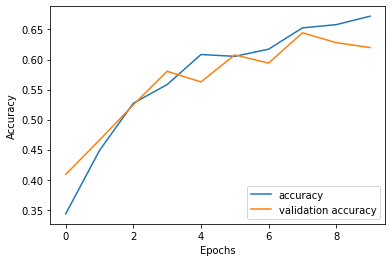

In [24]:
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim()
plt.legend(loc='lower right')
plt.show()

## Saving the Model

In [25]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [28]:
model.save("/content/gdrive/My Drive/Colab Models/cnn1.h5")
model2.save("/content/gdrive/My Drive/Colab Models/cnn2.h5")